# Conservación de energía en flujo en tubería 1‐D

## Workshop - Introducción a OpenFOAM para la Ingeniería Química


<img src="../Documentacion/Figuras/Fig_1_Seccion_1.1_c.png" alt="Alternative text" 
     align="right"
     width="500"/> 

La ecuación en derivadas parciales en una dimensión que describe el problema de transferencia de calor de un fluido en una tubería circular y su calentamiento por convección natural (Figura 1) esta dada por:

$$\rho \hat{C}_p \frac{\partial T}{\partial t} = k \frac{\partial^2 T}{\partial x^2} - \rho \hat{C}_p v_0 \frac{\partial T}{\partial x} - \frac{4 h(T-T_\text{aire})}{d_i} $$

Con condiciones de borde:

$$ CB1: T(x=0) = T_{in}$$

$$ CB2: \frac{d T}{d x}(x = L) = 0$$

Y condición inicial:

$$ CI: T(x, t=0) = T_{in}$$

La versión discretizada de esta ecuación que obtuvimos al aplicar el [método de volúmenes finitos](https://github.com/openfoam-ICL-UC/openfoam_intro_ES/wiki/Conservaci%C3%B3n-de-energ%C3%ADa-en-flujo-en-tuber%C3%ADa-1%E2%80%90D) y considerando para las derivadas espaciales un esquema central para el término de transporte de calor por conducción y Upwind para el término de transporte de calor por convección, mientras que un esquema Eurler hacia adelante para la derivada temporal.

### Importar módulos

In [21]:
# Mejorar calidad de gráficos en Jupyter Notebook
#%matplotlib notebook

# Visualización de datos y gráficos
import matplotlib
import matplotlib.pyplot as plt 

# Computación numérica
import numpy as np

# Función para integración numérica
from scipy.integrate import solve_ivp

### Inicializar las variables y parámetros del problema

In [22]:
# Parámetros constantes conocidos

# Largo de la tubería / m
L = 1

# Diámetro interno de la tubería / m
di = 0.0254*2

# Velocidad del fluido / m s^-1
u0 = 0.1

# Temperatura del aire / K
Taire = 273.15 + 25

# Temperatura de entrada del fluido / K
Tin = 70

# Coeficiente de transferencia de calor por convección natural / W m^-2 K^-1 
h = 25

# Propiedades del Nitrogeno liquido a 70 K y 1 atm
# Densidad del fluido / kg m^-3
rho = 838.645

# Viscosidad / Pa s
mu = 2.2e-4

# Conductividad termica / W m^-1 K^-1 
k = 0.16

# Capacidad calorífica a presión constante / J kg^-1 K^-1
Cp = 2014.03

# Difusividad térmica / m^2 s^-1
alpha = k / (rho * Cp) 

# Prandtl number Pr=(mu/rho)/alpha
Pr = (mu/rho)/alpha
print('Pr = ',Pr)

Pr =  2.7692912499999998


### Generar la grilla 1-D y espaciamiento espacial

In [23]:
# Grilla en coordenada x a lo largo de la tubería

# Tupla que contiene el valor de x inicial y final
x_rango = (0, L)

# Número de puntos en la grilla
N = 100

# Espaciamiento espacial
dx = L/N
dx_half = dx/2


# Vector con coordenadas en x
# el vector x_grilla almacena las coordenadas de los puntos centrales (P) de cada volumen de control
x_grilla = np.linspace(dx_half, L-dx_half, N)

print('dx = ',dx)
print(x_grilla)

dx =  0.01
[0.005 0.015 0.025 0.035 0.045 0.055 0.065 0.075 0.085 0.095 0.105 0.115
 0.125 0.135 0.145 0.155 0.165 0.175 0.185 0.195 0.205 0.215 0.225 0.235
 0.245 0.255 0.265 0.275 0.285 0.295 0.305 0.315 0.325 0.335 0.345 0.355
 0.365 0.375 0.385 0.395 0.405 0.415 0.425 0.435 0.445 0.455 0.465 0.475
 0.485 0.495 0.505 0.515 0.525 0.535 0.545 0.555 0.565 0.575 0.585 0.595
 0.605 0.615 0.625 0.635 0.645 0.655 0.665 0.675 0.685 0.695 0.705 0.715
 0.725 0.735 0.745 0.755 0.765 0.775 0.785 0.795 0.805 0.815 0.825 0.835
 0.845 0.855 0.865 0.875 0.885 0.895 0.905 0.915 0.925 0.935 0.945 0.955
 0.965 0.975 0.985 0.995]


In [24]:
# Cell Peclet number
# for central differencing Pe < 2
Pe = rho*u0/((rho*alpha)/dx)
print('Cell Peclet numer = ',Pe)

Cell Peclet numer =  10556.601183437502


### Definiendo espaciamiento temporal

In [25]:
# Courant–Friedrichs–Lewy number
CFL_max = 1.0
dt_CFL = CFL_max * 2 * dx / u0
print('dt (CFL) <= ',dt_CFL)

# rho*Cp*dx/dt > 2*k/dx
dt_cond = rho*Cp*dx**2/(2*k)
print('dt (cond) <= ',dt_cond)

# Espaciamiento temporal
dt = min(dt_CFL,dt_cond)
dt = dt/5
print('dt ',dt)

# Tiempo inicial
t_inicial = 0.0

# Tiempo final
t_final = 12 #dt*1e5
print('final time = ',t_final)

#Condición inicial de temperatura
T = np.ones(N) * Tin 

dt (CFL) <=  0.19999999999999998
dt (cond) <=  527.8300591718751
dt  0.039999999999999994
final time =  12


### Definir los coefficients de la matriz A y el vector b

La ecuación discretizada por el método de volúmenes finitos puede escribirse en forma matricial como:

$$ a_P \mathbf{T}^{n+1} = \mathbf{A}\mathbf{T}^{n} + \mathbf{b}$$

#### Discretización para los volúmenes de control internos:

$$ \frac{\rho C_p \Delta x}{\Delta t} T_P^{n+1} = \left(\frac{k}{\Delta x}\right)T_E^n + \left(\rho C_p v_0 + \frac{k}{\Delta x}\right)T_W^n + \left(\frac{\rho C_p \Delta x}{\Delta t} -\rho C_p v_0 -2\frac{k}{\Delta x} - \frac{4 h \Delta x}{d_i}\right)T_P^n + \frac{4 h\Delta x}{d_i}T_\text{aire}$$

Podemos definir los siquientes coeficientes:

$$ a_P T_P^{n+1} = a_E T_E^n + a_W T_W^n + a_P' T_P^n + S_u$$

$$ a_P = \frac{\rho C_p \Delta x}{\Delta t}$$

$$ a_E = \frac{k}{\Delta x}$$

$$ a_W = \rho C_p v_0 + \frac{k}{\Delta x}$$

$$ S_p = - \frac{4 h \Delta x}{d_i}$$

$$ a_P' = a_P - (a_E + a_W) + S_p$$

$$ S_u = \frac{4 h \Delta x}{d_i}T_\text{aire}$$

In [26]:
# Volúmenes de control internos
aP = rho*Cp*dx/dt

aE = k/dx

aW = rho*Cp*u0 + k/dx

Sp = -4*h*dx/di

aP_n = aP - (aE + aW) + Sp

Su = 4*h*Taire*dx/di

print('aP = %.1f' %aP)
print('aE = %.1f' %aE)
print('aW = %.1f' %aW)
print('|sum a_nb|/|aP_n| = %.3f' %(abs(aE+aW)/abs(aP_n)))

aP = 422264.0
aE = 16.0
aW = 168921.6
|sum a_nb|/|aP_n| = 0.667


#### Discretización de condición de borde 1 (CB1) en primer volumen de control:

$$T(x=0,t) = T_{in} \rightarrow T_{1-1/2}^n = T_{in}$$

Sustituyendo en la ecuacion discretizada:

$$ \rho C_p \frac{T_1^{n+1} - T_1^n}{\Delta t} = - \frac{\rho C_p v_0}{\Delta x}\left(T_1^n-T_{in}\right) + \frac{1}{\Delta x}\left(k\left(\frac{T_2^n-T_1^n}{\Delta x}\right) - k\left(\frac{T_1^n - T_{in}}{\Delta x/2}\right)\right) - \frac{4 h(T_1^n-T_\text{aire})}{d_i}$$

Reordenando términos:

$$\frac{\rho C_p\Delta x}{\Delta t} T_1^{n+1} = \left(\frac{k}{\Delta x}\right)T_2^n + \left(\frac{\rho C_p\Delta x}{\Delta t} - \rho C_p v_0-\frac{3 k}{\Delta x} -\frac{4 h\Delta x}{d_i}\right)T_1^n + \left(\rho C_p v_0 + \frac{2 k}{\Delta x}\right)T_{in} + \frac{4 h \Delta x}{d_i}T_{aire}$$

$$ a_P = \frac{\rho C_p \Delta x}{\Delta t}$$

$$ a_E = \frac{k}{\Delta x}$$

$$ a_W = 0$$

$$ S_p = - \frac{4 h \Delta x}{d_i}$$

$$ a_P' = a_P - a_E - \rho C_p v_0 -\frac{2 k}{\Delta x} + S_p $$

$$ S_u = \left(\rho C_p v_0 + \frac{2 k}{\Delta x}\right)T_{in} + \frac{4 h \Delta x}{d_i}T_{aire}$$

In [27]:
# Volúmen de control en boundary x=0 
aP_bc1 = aP

aE_bc1 = aE

aW_bc1 = 0

Sp_bc1 = Sp

aP_n_bc1 = aP_bc1 -rho*Cp*u0 - 3*k/dx + Sp_bc1

Su_bc1 = (rho*Cp*u0 + 2*k/dx)*Tin + Su

print('aP (BC1) = %.1f' %aP_bc1)
print('aE (BC1) = %.1f' %aE_bc1)
print('aW (BC1) = %.1f' %aW_bc1)
print('|sum a_nb|/|aP_n| (BC1) = %.3f' %(abs(aE_bc1+aW_bc1)/abs(aP_n_bc1)))

aP (BC1) = 422264.0
aE (BC1) = 16.0
aW (BC1) = 0.0
|sum a_nb|/|aP_n| (BC1) = 0.000


#### Discretización de condicion de borde 2 (CB2) en último volumen de control:

$$\frac{d T}{d x}(x=L,t) = 0 \rightarrow \frac{T_{N+1/2} - T_{N}}{\Delta x/2} = 0 \rightarrow T_{N+1/2}^n = T_N^n$$

Sustituyendo en la ecuacion discretizada:

$$ \rho C_p \frac{T_N^{n+1} - T_N^n}{\Delta t} = - \frac{\rho C_p v_0}{\Delta x}\left(T_N^n-T_{N-1}^n\right) + \frac{1}{\Delta x}\left(k\left(\frac{T_{N+1/2}^n-T_N^n}{\Delta x/2}\right) - k\left(\frac{T_N^n - T_{N-1}^n}{\Delta x}\right)\right) - \frac{4 h(T_N^n-T_\text{aire})}{d_i}$$

$$ \rho C_p \frac{T_N^{n+1} - T_N^n}{\Delta t} = - \frac{\rho C_p v_0}{\Delta x}\left(T_N^n-T_{N-1}^n\right) + \frac{1}{\Delta x}\left(0 - k\left(\frac{T_N^n - T_{N-1}^n}{\Delta x}\right)\right) - \frac{4 h(T_N^n-T_\text{aire})}{d_i}$$

Reordenando términos:

$$\frac{\rho C_p\Delta x}{\Delta t} T_N^{n+1} = \left(\frac{\rho C_p\Delta x}{\Delta t} - \rho C_p v_0 -\frac{k}{\Delta x} -\frac{4 h\Delta x}{d_i}\right)T_N^n + \left(\rho C_p v_0 + \frac{k}{\Delta x}\right)T_{N-1}^n + \frac{4 h \Delta x}{d_i}T_{aire}$$

$$ a_P = \frac{\rho C_p \Delta x}{\Delta t}$$

$$ a_E = 0$$

$$ a_W = \rho C_p v_0 + \frac{k}{\Delta x}$$

$$ S_p = - \frac{4 h \Delta x}{d_i}$$

$$ a_P' = a_P - (a_E + a_W) + S_p $$

$$ S_u = \frac{4 h \Delta x}{d_i}T_{aire}$$

In [28]:
# Volúmen de control en boundary x=L
aP_bc2 = aP

aE_bc2 = 0

aW_bc2 = aW

Sp_bc2 = Sp

aP_n_bc2 = aP_bc2 - rho*Cp*u0 - k/dx  + Sp_bc2

Su_bc2 = Su

print('aP (BC2) = %.1f' %aP_bc2)
print('aE (BC2) = %.1f' %aE_bc2)
print('aW (BC2) = %.1f' %aW_bc2)
print('|sum a_nb|/|aP_n| (BC2) = %.3f' %(abs(aE_bc2+aW_bc2)/abs(aP_n_bc2)))

aP (BC2) = 422264.0
aE (BC2) = 0.0
aW (BC2) = 168921.6
|sum a_nb|/|aP_n| (BC2) = 0.667


In [29]:
# Vector b
b = np.ones(len(T))
b[0] = Su_bc1
for i in range(1,N-1):
    b[i] = Su
b[-1] = Su_bc2

# Matriz de coeficientes
A = np.zeros([N, N])
A[0][0] = aP_n_bc1
A[0][1] = aE_bc1
for i in range(1,N-1):
    # Coeficientes del volúmen de control de la izquierda, (i-1)
    A[i, i-1] = aW
    
    # Coeficientes del volúmen de control central, i
    A[i, i] = aP_n
        
    # Coeficientes del volúmen de control de la derecha, i + 1
    A[i, i+1] = aE

A[N-1][N-1] = aP_n_bc2
A[N-1][N-2] = aW_bc2


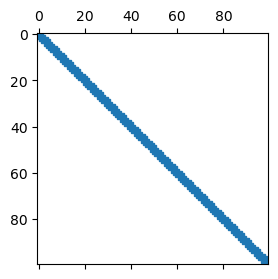

In [30]:
# Creamos un gráfico de N x N
fig, ax = plt.subplots(1, 1, figsize = [3,3])

# Graficamos spy
ax.spy(A, markersize = 3)
plt.show()

### Iteración

In [31]:
# Lista con los perfiles de temperatura para cada tiempo almacenado
T_sol = []

# Copiar vector inicial de temperatura
T_old = np.copy(T)

# Inicializar tiempo
t = 0

# Lista para almacenar los timepos en los cuales se almacenan las soluciones del perfil de temperatura
times = []

# Inicializar contador que se utiliza para almacenar las soluciones
n = 1

# Loop para avanzar en el tiempo 
while t < t_final:
    # Contruir nuevo vector de temperatura
    T_new = (np.dot(A,T_old) + b)*(1/aP)

    # Progresar timepo con dt
    t += dt

    # Incrementar contador
    n += 1

    # Reemplazar antiguo vector de temperatura con nuevo perfil calculado
    T_old = np.copy(T_new)
    
    # Almacenar solucion
    if round(n%50) == 0:
        T_sol.append(T_new)
        print(t)
        times.append(t)

1.960000000000001
3.9600000000000026
5.960000000000004
7.960000000000006
9.959999999999964
11.959999999999921


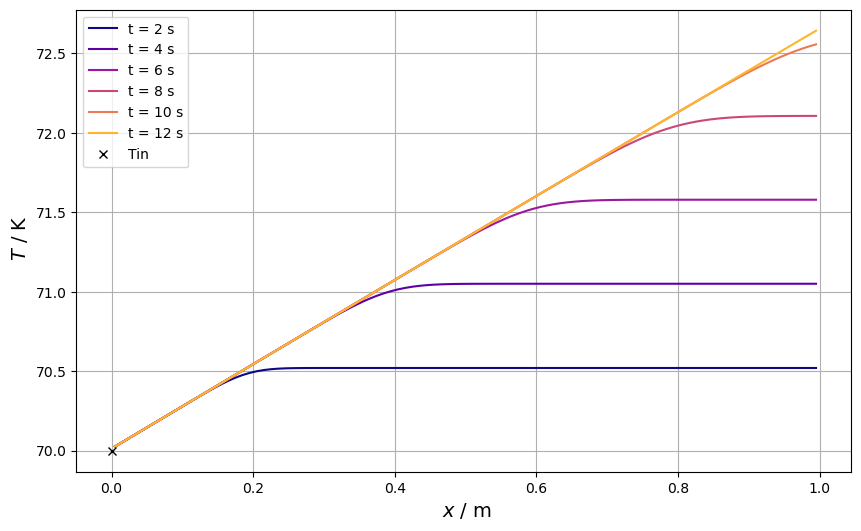

In [32]:
# Visualizar el perfil de temperatura a lo largo de la tubería
fig, ax = plt.subplots(1, 1, figsize = [10,6])

# Largo del vector de soluciones de temperatura
n_temp = len(T_sol)

plasma = matplotlib.colormaps['plasma']
colour = [plasma(i/n_temp) for i in range(n_temp)]

# Graficar perfiles almacenados
for j in range(len(T_sol)):
    plt.plot(x_grilla, T_sol[j], color = colour[j], label = "t = %.0f s" % times[j])

plt.plot(0,Tin,'xk',label = "Tin")

plt.xlabel(' $x$ / m', size = 14)
plt.ylabel(' $T$ / K', size = 14)
plt.grid()
plt.legend()
plt.show()

In [33]:
## Calcular la temperatura promedio en toda la tuberia

# Area transversal de la turbería / m^2
A = np.pi*(di/2)**2

# Integrar el perfil de temperatura a lo largo de la tubería para obtener la temperatura promedio
Tmean = []
for j in range(len(T_sol)):
    temp = np.sum(T_sol[j])/N
    Tmean.append(temp)

# Agregar calculo con trapz
#Tmean2 = np.trapz(Tub, x=X)
print('Temperatura promedio en la tuberia en tiempo final = %.3f K' %Tmean[-1])


Temperatura promedio en la tuberia en tiempo final = 71.337 K


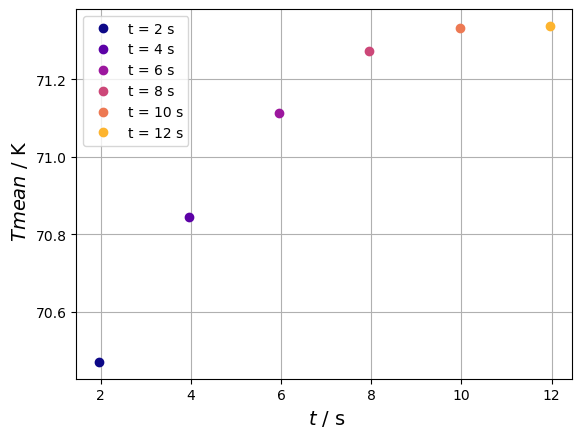

In [34]:
# Visualizar temperatura promedio a lo largo del tiempo
for j in range(len(T_sol)):
    plt.plot(times[j], Tmean[j], 'o', color = colour[j], label = "t = %.0f s" % times[j])

plt.xlabel(' $t$ / s', size = 14)
plt.ylabel(' $Tmean$ / K', size = 14)
plt.grid()
plt.legend()
plt.show()

In [35]:
# Calcular el flux de calor por convección natural transferido por el manto de la tuberia en cada punto a lo largo de la grilla
Atub_CV = 2*np.pi*(di/2)*dx

Q = []
for j in range(len(T_sol)):
    Qtemp = -h*(T_sol[j] - Taire)*Atub_CV #W
    Q.append(Qtemp)

# Calcular flux de calor total 
Qtot = np.sum(Q[-1])
print('Flux de calor total en tiempo final = %.3f W\n' %Qtot)

Flux de calor total en tiempo final = 904.942 W



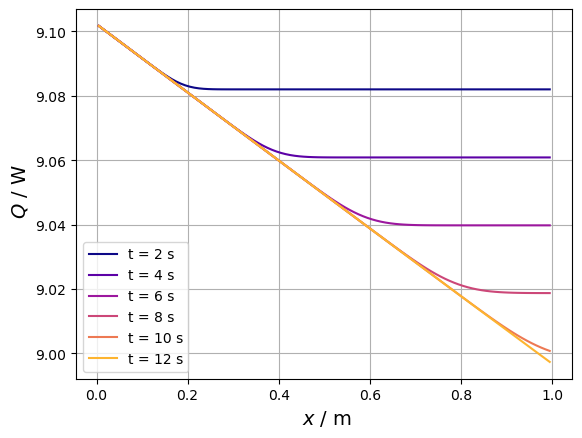

In [36]:
# Visualizar flux de calor a lo largo de la tubería
for j in range(len(T_sol)):
    plt.plot(x_grilla, Q[j], color = colour[j], label = "t = %.0f s" % times[j])

plt.xlabel(' $x$ / m', size = 14)
plt.ylabel(' $Q$ / W', size = 14)
plt.grid()
plt.legend()
plt.show()